# QSP angle estimation with noise

We consider learning QSP sequences that are robust to noise. 


Consider two approaches...

### 1
Suppose each use of $R_X(\theta)$ is noisy according to some distribution on the true angle $\theta^*$. We define the sequence of $X$-rotation angles as $\Theta = \{\theta_1, \dots , \theta_k\}$. In a i.i.d. noise setting, we consider that each $\theta_i$ be distributed according to  some distribution $p$. In the non-markovian setting we can define some joint probability distribution over all $\theta_i$. Suppose we have determined $\Phi = \{\phi_0, \dots , \phi_k\}$. Recall the QSP sequence

$$
\begin{equation}
    U_\Phi(x) = e^{i \phi_0 \sigma_x} \prod_{j=1}^{k} \left(W(x) e^{i \phi_j \sigma_x}\right)  = 
    \begin{pmatrix}
        P(x) & i\sqrt{1 - x^2}Q(X)\\
        i\sqrt{1 - x^2}Q^*(x) & P^*(x)
    \end{pmatrix}.
\end{equation}
$$

Let's rewrite this in terms of each $\theta_i$.

$$
\begin{equation}
    U'_{\Phi}(\Theta) = e^{i \phi_0 \sigma_x} \prod_{j=1}^{k} \left(R_X(\theta_j) e^{i \phi_j \sigma_x}\right)
\end{equation}
$$

$$
\begin{equation}
    W(x) = R_X(\theta) = 
    \begin{pmatrix}
        x & i \sqrt{1 - x^2}\\
        i \sqrt{1 - x^2} & x
    \end{pmatrix}.
\end{equation}
$$

Let the real part of upper left entry of the matrix be
$$ P'_{\Phi}(\Theta) = \Re(U'_{\Phi}(\Theta)_{1,1}). $$
 


Then the expected Z operator measurement is

$$
\int_{\Theta \in (-\pi, \pi)^k} P'_{\Phi}(\Theta) ~p(\theta_1)\dots p(\theta_k)~ d\theta_1 \dots d\theta_k.
$$

In the case were we are optimizing $P'_{\Phi}(\Theta)$ with respect ot $\Phi$ over some function $f(x) = f'(\theta = arccos(x))$. Then we can define the error (MSE) as.

$$
\int_{\Theta \in (-\pi, \pi)^k} (f'(\theta ^*) - P'_{\Phi}(\Theta))^2 ~p(\theta_1)\dots p(\theta_k)~ d\theta_1 \dots d\theta_k
$$ 

This error term can technically be used with gradient descent to produce $\Phi$ that are robust to noise for some discrete set of desired behavior. There are some numerical concersn though: the number of terms contributing to the gradient for each $\phi$ grows exponentially with each additional term in the QSP sequence. It also additionally must start out very high even with $k=1$ since approximating an integral requires many samples. Generally the number of samples required for the integral to converge is greater for more complex integrals. This one is certaintly not simple. 

### 2

We can also feed our model input $\Theta$ according to some distribution representing noise. 

In [1]:
from qsp_layers import *

# visualization tools
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import IPython

sns.set()

In [2]:
InteractiveShell = IPython.core.interactiveshell.InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
def plot(history):
    plt.plot(history.history['loss'])
    plt.title("Learning QSP Angles")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.show()


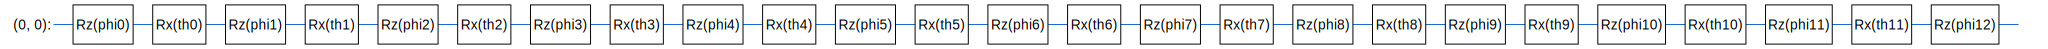

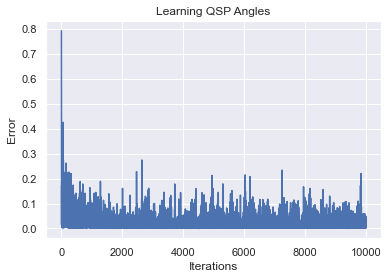

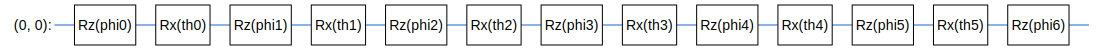

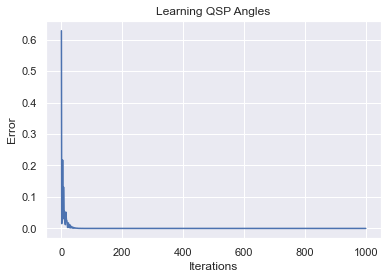

<AxesSubplot:xlabel='theta', ylabel='vals'>

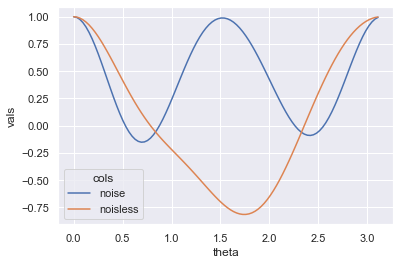

In [27]:
N = 12
q = cirq.GridQubit(0, 0)
phis = [sympy.Symbol(f'phi{k}') for k in range(N + 1)]
thetas = [sympy.Symbol(f'th{k}') for k in range(N)]

circuit = cirq.Circuit(cirq.rz(phis[0])(q))

for k in range(1,N+1):
    c = cirq.Circuit(
        cirq.rx(thetas[k-1])(q),
        cirq.rz(phis[k])(q)
    )
    circuit.append(c)

controlled_qsp = HybridControlledPQC(circuit,operators = cirq.Z(q),
                      controlled_symbol_names=thetas,
                      native_symbol_names=phis)

theta_in = tf.keras.Input(shape=(1,),
                        # The circuit-tensor has dtype `tf.string` 
                        dtype=tf.float32,
                    name='theta')

noise = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(N),
    tf.keras.layers.Flatten(),
    tf.keras.layers.GaussianNoise(0.1)
])

noisy_theta = noise(theta_in)

measurement = controlled_qsp(noisy_theta)

model = tf.keras.Model(inputs=theta_in, outputs=measurement)

SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

# The command input values to the classical NN.
th_in = np.array([[np.pi/4],[3*np.pi/4]], dtype=np.float32)
# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[0],[0]], dtype=np.float32)

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=10000,
    verbose=0)

plot(history)

# noiseless model ======================================================

N = 6
q = cirq.GridQubit(0, 0)
phis = [sympy.Symbol(f'phi{k}') for k in range(N + 1)]
thetas = [sympy.Symbol(f'th{k}') for k in range(N)]

circuit = cirq.Circuit(cirq.rz(phis[0])(q))

for k in range(1,N+1):
    c = cirq.Circuit(
        cirq.rx(thetas[k-1])(q),
        cirq.rz(phis[k])(q)
    )
    circuit.append(c)

controlled_qsp = HybridControlledPQC(circuit,operators = cirq.Z(q),
                      controlled_symbol_names=thetas,
                      native_symbol_names=phis)

theta_in = tf.keras.Input(shape=(1,),
                        # The circuit-tensor has dtype `tf.string` 
                        dtype=tf.float32,
                    name='theta')

noise = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(N),
    tf.keras.layers.Flatten()
])

noisy_theta = noise(theta_in)

measurement = controlled_qsp(noisy_theta)

model_noiseless = tf.keras.Model(inputs=theta_in, outputs=measurement)

SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model_noiseless.compile(optimizer=optimizer, loss=loss)

# The command input values to the classical NN.
th_in = np.array([[np.pi/4],[3*np.pi/4]], dtype=np.float32)
# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[0],[0]], dtype=np.float32)

history = model_noiseless.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)



# plotting =================================================================
all_th = np.arange(0,np.pi,np.pi/100)
out_noiseless = tf.reshape(model_noiseless.predict(all_th), (len(all_th,)))
out = tf.reshape(model.predict(all_th), (len(all_th,)))
df = pd.DataFrame({'theta': all_th,'noise': out, 'noisless': out_noiseless})
df = df.melt('theta', var_name='cols',  value_name='vals')
sns.lineplot(x='theta', y="vals", hue='cols', data=df)
plt.show() 
